# 场景生成

In [88]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [89]:
# !unset http_proxy && unset https_proxy

In [90]:
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from pipeline_controlnet_inpaint import StableDiffusionControlNetInpaintPipeline

from transformers import AutoTokenizer, PretrainedConfig
import torch
import os.path as osp

In [91]:
def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel
        return CLIPTextModel
    
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation
        return RobertaSeriesModelWithTransformation
    else:
        raise ValueError(f"{model_class} is not supported.")

In [92]:
ctrl_path = './rege_ctrl'

controlnet = ControlNetModel.from_pretrained(osp.join(ctrl_path, 'controlnet'))

tokenizer = AutoTokenizer.from_pretrained(osp.join(ctrl_path, 'tokenizer'),use_fast=False)


sd_inpainting_model_name = "stabilityai/stable-diffusion-2-inpainting"
# import correct text encoder class
text_encoder_cls = import_model_class_from_model_name_or_path(sd_inpainting_model_name, None)

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(osp.join(ctrl_path, "scheduler"))

text_encoder = text_encoder_cls.from_pretrained(osp.join(ctrl_path, "text_encoder"))

vae = AutoencoderKL.from_pretrained(osp.join(ctrl_path, "vae"))

unet = UNet2DConditionModel.from_pretrained(osp.join(ctrl_path, "unet"))

weight_dtype = torch.float32

pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    sd_inpainting_model_name,
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    controlnet=controlnet,
    safety_checker=None,
    revision=None,
    torch_dtype=weight_dtype,
)

print("End loading")

pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to('cuda')
pipeline.set_progress_bar_config(disable=True)

/root/miniconda3/envs/rep/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 2551.80it/s]


End loading


### Inference 推理图片

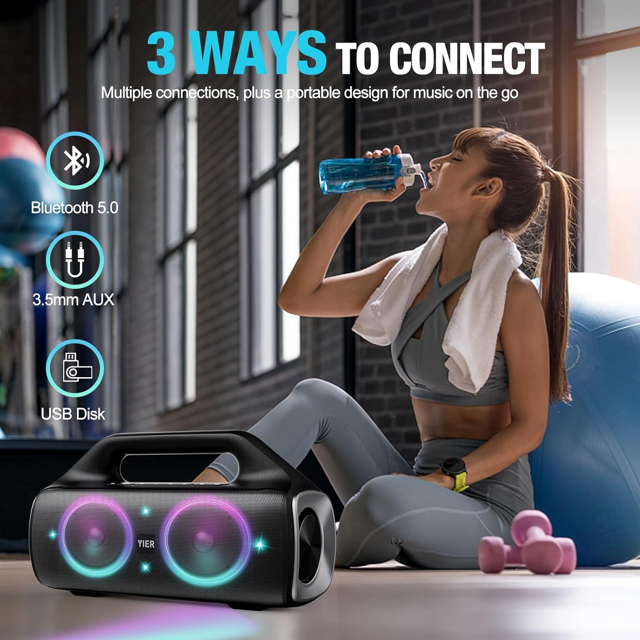

In [93]:
from PIL import Image, ImageOps
import requests
from io import BytesIO
from efficient_sam import create_canvas_and_transform_image

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

img_name = 'imgs/radio.jpg'

img = Image.open(img_name).convert('RGB')
img_size = (640, 640)
img = resize_with_padding(img, img_size)

img

### 显示Resize过后的图片

In [94]:
import cv2
import re
import torch
import zipfile
import os.path as osp
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from efficient_sam.build_efficient_sam import efficient_sam_model_registry
from efficient_sam.utils import show_mask, show_points, show_box


device = "cuda"
model_type = 'vit_s'
sam_weight_path = 'rege_ctrl/effsam_weights'
with zipfile.ZipFile(f"{sam_weight_path}/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall(f"{sam_weight_path}")
    
model = efficient_sam_model_registry[model_type](checkpoint=osp.join(f'{sam_weight_path}','efficient_sam_vits.pt'))

### Efficient SAM

(-0.5, 639.5, 639.5, -0.5)

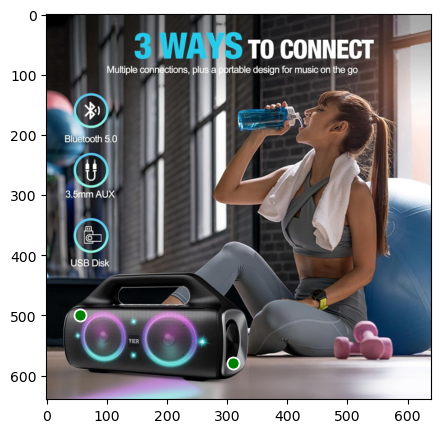

In [95]:
input_points = torch.tensor([[[[56, 499], [310, 580]]]])
input_labels = torch.tensor([[[1, 1]]])
plt.figure(figsize=(5,5))
sample_image_np = np.array(img)
plt.imshow(sample_image_np)
show_points(input_points.numpy(), input_labels.numpy(), plt.gca())
plt.axis('on')

In [96]:
def find_border(mask):
    top = np.argmax(mask.sum(axis=1) > 0)   # 上边界
    bottom = len(mask) - np.argmax(mask[::-1].sum(axis=1) > 0)# 下边界
    left = np.argmax(mask.sum(axis=0) > 0)  # 左边界
    right = len(mask[0]) - np.argmax(mask[:,::-1].sum(axis=0) > 0)  # 右边界

    return top, bottom, left, right


def get_crop_image_mask(sample_image_np, mask):
    # 保存为带有透明度的四通道BGRA格式：
    sample_image_np = sample_image_np.copy().astype(np.uint8)
    sample_image_np = cv2.cvtColor(sample_image_np, cv2.COLOR_RGB2BGRA)  # 转换为带有透明度的图像
    mask = np.where(mask, 255, 0).astype(np.uint8)
    sample_image_np[:,:,3] = mask  # 设置透明度
    # 找到蒙版的边界
    top, bottom, left, right = find_border(mask)
    # 根据边界裁剪图像
    cropped_image = sample_image_np[top:bottom, left:right]
    # 保存裁剪后的结果为带有透明度的PNG格式
    return cropped_image

In [97]:
sample_image_tensor = transforms.ToTensor()(sample_image_np)

predicted_logits, predicted_iou = model(
    sample_image_tensor[None, ...],
    input_points,
    input_labels,
)
sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
predicted_logits = torch.take_along_dim(
    predicted_logits, sorted_ids[..., None, None], dim=2
)

bin_mask = torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

cropped_image = get_crop_image_mask(sample_image_np, bin_mask)

### 商品的几何变换

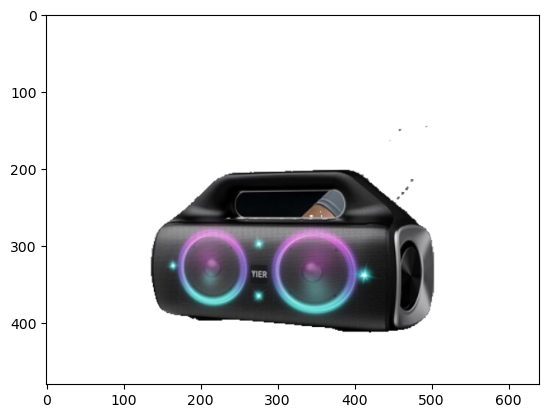

In [98]:
canvas_size = (480, 640)  # Example canvas size
scale_factor = 1.2  # Example scaling factor
rotation_angle = 0  # Example rotation angle in degrees
translation_xy = (0, 40)  # Example translation (x, y)

# Perform transformations and get the final image and mask
img_geo, mask = create_canvas_and_transform_image(
    cropped_image, canvas_size, scale_factor, rotation_angle, translation_xy)

img_geo = cv2.cvtColor(img_geo, cv2.COLOR_BGRA2RGBA)
plt.imshow(img_geo)
plt.show()

### 显示对应的mask

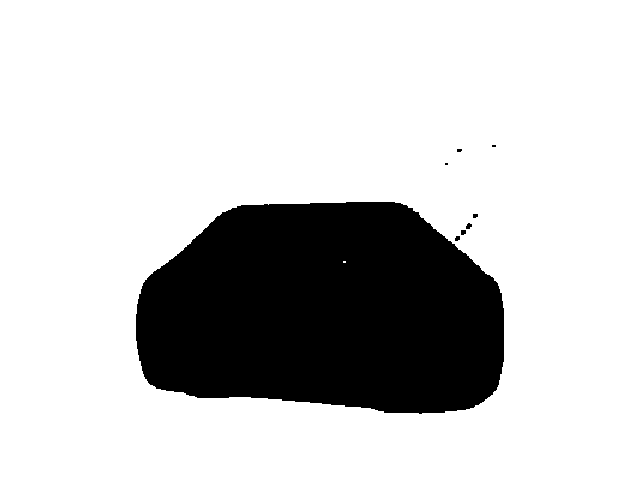

In [99]:
prompt = "radio in the park"
mask = np.where(mask, 255, 0).astype(np.uint8)
mask = Image.fromarray(mask , 'L')
mask = ImageOps.invert(mask)

mask

## Stable Diffusion with Controlnet (cond_scale = 1)

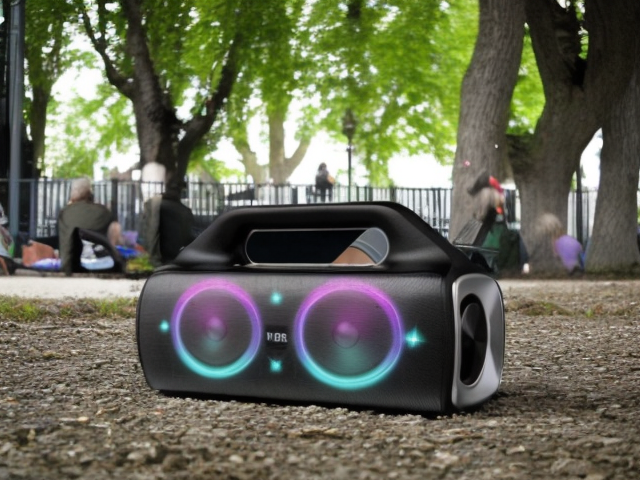

In [100]:
seed = 68
generator = torch.Generator(device='cuda').manual_seed(seed)
cond_scale = 1.0
img_geo = Image.fromarray(img_geo)

with torch.autocast("cuda"):
    controlnet_image = pipeline(
        prompt=prompt, 
        image=img_geo, 
        mask_image=mask,
        control_image=mask, 
        num_images_per_prompt=1, 
        generator=generator, 
        num_inference_steps=20, 
        guess_mode=False, 
        controlnet_conditioning_scale=cond_scale
    ).images[0]
    
# controlnet_image

mask_image = mask.convert('1')
mask_image = ImageOps.invert(mask_image)

# 使用paste方法，根据mask覆盖掉ctrl_img中对应区域的像素
controlnet_image.paste(img, (0, 0), mask_image)

controlnet_image